In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import xgboost as xgb
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [3]:
model_path_name = "all_features_model_fully_tuned"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

In [4]:
if not os.path.exists(DIRECTORY_PATH):
    os.makedirs(DIRECTORY_PATH)
with open(MODEL_INFO_FILEPATH, "w") as text_file:
    print(f"##### MODEL INFO #####", file=text_file)
    print(f"All features model. Robust tuning", file=text_file)

In [5]:
dataset = pd.read_pickle("datasets/dummy_dataset.pkl")

In [6]:
print(dataset.shape[0]*.80)
print(dataset.shape[0]*.10)

15791.2
1973.9


In [7]:
train_index_stop = 15893 # this is the first index of a new pitcher
val_index_stop = 17898 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

In [8]:
train_X = training_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
train_y = training_set['RUNPASS']

val_X = validation_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
val_y = validation_set['RUNPASS']

test_X = test_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
test_y = test_set['RUNPASS']

In [9]:
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Input features: {train_X.columns.values}", file=text_file)

In [10]:
# have to convert to numerics for XGBoost 
mapping = {'R' : 0,
           'P': 1
           }

In [11]:
train_y = train_y.map(mapping)
val_y = val_y.map(mapping)
test_y = test_y.map(mapping)

In [12]:
train_y.value_counts(normalize=True)

RUNPASS
1    0.610835
0    0.389165
Name: proportion, dtype: float64

In [13]:
bparams = {'max_depth': 6,
 'learning_rate': 0.23414476853402916,
 'n_estimators': 800,
 'subsample': 0.7000000000000001,
 'min_child_weight': 4}

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **bparams)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

[0]	validation_0-error:0.35960	validation_0-logloss:0.62246	validation_0-auc:0.73829
[1]	validation_0-error:0.34264	validation_0-logloss:0.60001	validation_0-auc:0.74675
[2]	validation_0-error:0.33516	validation_0-logloss:0.58605	validation_0-auc:0.74968
[3]	validation_0-error:0.31920	validation_0-logloss:0.57524	validation_0-auc:0.75367
[4]	validation_0-error:0.30324	validation_0-logloss:0.56490	validation_0-auc:0.76291
[5]	validation_0-error:0.30125	validation_0-logloss:0.55821	validation_0-auc:0.76561
[6]	validation_0-error:0.29476	validation_0-logloss:0.55366	validation_0-auc:0.76779
[7]	validation_0-error:0.29576	validation_0-logloss:0.55014	validation_0-auc:0.77022
[8]	validation_0-error:0.29676	validation_0-logloss:0.54892	validation_0-auc:0.77027
[9]	validation_0-error:0.29875	validation_0-logloss:0.54814	validation_0-auc:0.76845
[10]	validation_0-error:0.29776	validation_0-logloss:0.54643	validation_0-auc:0.76919
[11]	validation_0-error:0.30873	validation_0-logloss:0.54728	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23414476853402916, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
clf.evals_result()['validation_0']['error'][clf.best_iteration]

0.2967581047381546

In [18]:
clf.evals_result()['validation_0']['auc'][clf.best_iteration]

0.770273315588513

In [15]:
# clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
#                                         objective='objective=multi:softmax', eval_metric=['merror','mlogloss'])
# clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

In [19]:
def objective(trial, train_X, train_y, val_X, val_y):
    param = {
             "max_depth": trial.suggest_int('max_depth', 1, 20,step=1),
              "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
              "n_estimators": trial.suggest_int('n_estimators', 50, 1050,step=100),
              "subsample" : trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
              "min_child_weight" : trial.suggest_int('min_child_weight', 1, 250, step=1), 
              "colsample_bytree" : trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
              "reg_lambda" : trial.suggest_float("reg_lambda", 0.001, 25, log=True)
            }
    clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=30,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **param)
    clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=0)  

    best_error = clf.evals_result()['validation_0']['error'][clf.best_iteration]
    return best_error


In [20]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda x : objective(x, train_X, train_y, val_X, val_y), n_trials=100)
print(study.best_trial)

[I 2024-05-07 01:22:04,806] A new study created in memory with name: no-name-e155392b-da9f-4b2d-9b44-1d61df4a4de0
[I 2024-05-07 01:22:13,285] Trial 0 finished with value: 0.30623441396508727 and parameters: {'max_depth': 3, 'learning_rate': 0.014499316552577557, 'n_estimators': 850, 'subsample': 0.7000000000000001, 'min_child_weight': 119, 'reg_lambda': 0.001311354214979335}. Best is trial 0 with value: 0.30623441396508727.
[I 2024-05-07 01:22:13,860] Trial 1 finished with value: 0.30324189526184536 and parameters: {'max_depth': 3, 'learning_rate': 0.16957232970414154, 'n_estimators': 50, 'subsample': 1.0, 'min_child_weight': 116, 'reg_lambda': 2.0515793161460407}. Best is trial 1 with value: 0.30324189526184536.
[I 2024-05-07 01:22:14,897] Trial 2 finished with value: 0.30623441396508727 and parameters: {'max_depth': 8, 'learning_rate': 0.1347233008190685, 'n_estimators': 550, 'subsample': 0.9, 'min_child_weight': 202, 'reg_lambda': 0.027389490929101697}. Best is trial 1 with value: 0

FrozenTrial(number=24, state=TrialState.COMPLETE, values=[0.2832917705735661], datetime_start=datetime.datetime(2024, 5, 7, 1, 23, 4, 152995), datetime_complete=datetime.datetime(2024, 5, 7, 1, 23, 7, 740427), params={'max_depth': 18, 'learning_rate': 0.04439148946862281, 'n_estimators': 450, 'subsample': 0.9, 'min_child_weight': 28, 'reg_lambda': 0.34178775695751923}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=20, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=1050, log=False, low=50, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1), 'min_child_weight': IntDistribution(high=250, log=False, low=1, step=1), 'reg_lambda': FloatDistribution(high=25.0, log=True, low=0.001, step=None)}, trial_id=24, value=None)


In [21]:
print(f"Best Params = {study.best_params}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Params = {study.best_params}", file=text_file)

Best Params = {'max_depth': 18, 'learning_rate': 0.04439148946862281, 'n_estimators': 450, 'subsample': 0.9, 'min_child_weight': 28, 'reg_lambda': 0.34178775695751923}


In [22]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=30,
                        objective='binary:logistic', eval_metric=['error','logloss', 'auc'], **study.best_params)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

[0]	validation_0-error:0.37357	validation_0-logloss:0.65278	validation_0-auc:0.74387
[1]	validation_0-error:0.37357	validation_0-logloss:0.64438	validation_0-auc:0.76180
[2]	validation_0-error:0.37357	validation_0-logloss:0.63693	validation_0-auc:0.76418
[3]	validation_0-error:0.37357	validation_0-logloss:0.62993	validation_0-auc:0.76592
[4]	validation_0-error:0.37357	validation_0-logloss:0.62398	validation_0-auc:0.76520
[5]	validation_0-error:0.37307	validation_0-logloss:0.61800	validation_0-auc:0.76627
[6]	validation_0-error:0.36110	validation_0-logloss:0.61251	validation_0-auc:0.76761
[7]	validation_0-error:0.34913	validation_0-logloss:0.60779	validation_0-auc:0.76735
[8]	validation_0-error:0.34414	validation_0-logloss:0.60331	validation_0-auc:0.76788
[9]	validation_0-error:0.34165	validation_0-logloss:0.59891	validation_0-auc:0.76916
[10]	validation_0-error:0.33865	validation_0-logloss:0.59504	validation_0-auc:0.76844
[11]	validation_0-error:0.33616	validation_0-logloss:0.59168	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=True, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04439148946862281, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=28, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
pickle.dump(clf, open(f"{DIRECTORY_PATH}/xgb_model.pkl", "wb"))

In [24]:
best_val_merror = clf.evals_result()['validation_0']['error'][clf.best_iteration]
best_val_mlogloss = clf.evals_result()['validation_0']['logloss'][clf.best_iteration]
best_val_auc = clf.evals_result()['validation_0']['auc'][clf.best_iteration]

print(f"Best Val error = {best_val_merror}")
print(f"Best Val logloss = {best_val_mlogloss}")
print(f"Best Val AUC = {best_val_auc}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Val error = {best_val_merror}", file=text_file)
    print(f"Best Val logloss = {best_val_mlogloss}", file=text_file)
    print(f"Best Val AUC = {best_val_auc}", file=text_file)

Best Val error = 0.286783042394015
Best Val logloss = 0.5385533984508969
Best Val AUC = 0.7788239946255304


In [25]:
#y_pred_probs = clf.predict_proba(val_X)

In [26]:
# y_pred_probs = clf.predict_proba(val_X)
y_pred = clf.predict(val_X)

print('\n------------------ Confusion Matrix -----------------\n')
cmatrix = confusion_matrix(val_y, y_pred)
print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)


------------------ Confusion Matrix -----------------

     R     P
R  394   355
P  220  1036


In [27]:
# row i represents all true class i
# recall = (np.diagonal(confusion_matrix)/np.sum(confusion_matrix,axis=1)).round(3)
print(classification_report(val_y, y_pred, target_names=list(mapping.keys())))

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(val_y, y_pred, target_names=list(mapping.keys())), file=text_file)

              precision    recall  f1-score   support

           R       0.64      0.53      0.58       749
           P       0.74      0.82      0.78      1256

    accuracy                           0.71      2005
   macro avg       0.69      0.68      0.68      2005
weighted avg       0.71      0.71      0.71      2005



In [28]:
# https://stackoverflow.com/questions/37340474/xgb-plot-tree-font-size-python
def plot_tree(xgb_model, filename, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    
    gvz = xgb.to_graphviz(xgb_model, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

In [29]:
plot_tree(clf, f"{DIRECTORY_PATH}/tree_graph.pdf")

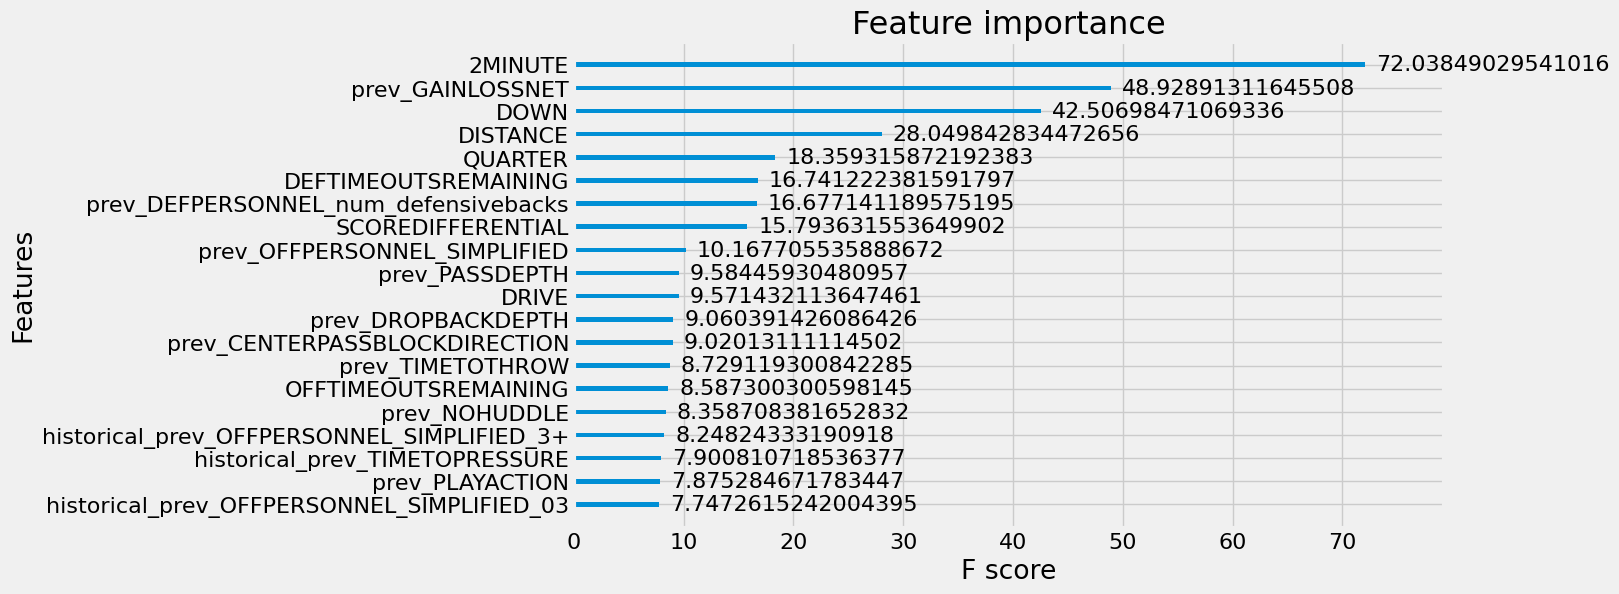

In [30]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.savefig(f"{DIRECTORY_PATH}/feature_importance.png", bbox_inches = 'tight')
plt.show()

In [31]:
from sklearn.metrics import accuracy_score
y_test_pred = clf.predict(test_X)

In [32]:
test_accuracy = accuracy_score(test_y, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Test Accuracy = {test_accuracy}", file=text_file)

Test Accuracy: 0.7180879956545356


In [33]:

print('\n------------------ TEST DATA Confusion Matrix -----------------\n')
test_cmatrix = confusion_matrix(test_y, y_test_pred)
print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ TEST DATA Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)
print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())))
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())), file=text_file)



------------------ TEST DATA Confusion Matrix -----------------

     R    P
R  413  306
P  213  909
              precision    recall  f1-score   support

           R       0.66      0.57      0.61       719
           P       0.75      0.81      0.78      1122

    accuracy                           0.72      1841
   macro avg       0.70      0.69      0.70      1841
weighted avg       0.71      0.72      0.71      1841

